In [129]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [130]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [131]:
train = pd.read_csv(open('train.csv'), sep = ',')
test = pd.read_csv(open('test.csv'), sep = ',')
train.shape, test.shape

((1460, 81), (1459, 80))

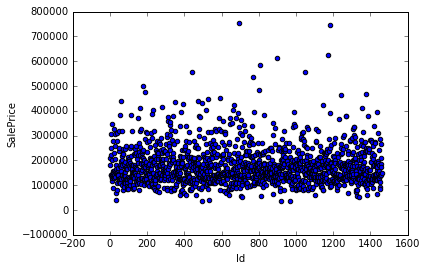

In [132]:
#Scatter plot of Id vs Sale Price
data = train[['Id','SalePrice']].values
#Plot part
plt.scatter(data[:,0],data[:,1]);
plt.xlabel('Id');
plt.ylabel('SalePrice');

In [133]:
type(train),type(test)


(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

In [134]:
train.isnull().values.any(),train.isnull().sum().sum()

(True, 6965)

In [135]:
train.isnull().values.sum().sum()

6965

In [136]:
train.shape, test.shape

((1460, 81), (1459, 80))

In [137]:
#Concat train and test data so as to avoid mismatch of number of features after applying pandas_dataframe.get_dummies
train_test_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],test.loc[:,'MSSubClass':'SaleCondition']))
train_test_data.shape

(2919, 79)

Categorical caolumns

In [138]:
categorical_columns = []
for column in train_test_data.columns.values:
    if train_test_data[column].dtype == 'object':
        categorical_columns.append(column)
    

In [139]:
train_numerical = train_test_data.drop(categorical_columns, axis=1)
train_categorical = train_test_data[categorical_columns]
train_numerical.columns.values, train_categorical.columns.values

(array(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
        'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
        'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
        '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
        'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
        'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
        'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
        'MoSold', 'YrSold'], dtype=object),
 array(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
        'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
        'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
        'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
        'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
        'BsmtFinType1', 'BsmtFinType2', 'Heating', 'Heat

Numerical data imputation

In [140]:
from scipy.stats import skew
from sklearn.preprocessing import Normalizer
for column in train_numerical.columns.values: 
    if(train_numerical[column].isnull().sum() > 100):
        train_numerical = train_numerical.drop(column, axis = 1)
        print "[%s] column is dropped!" %column
    elif (train_numerical[column].isnull().sum().sum() > 0):
        train_numerical = train_numerical.fillna(train_numerical[column].median())
    
        outlier = np.where(is_outlier(train_numerical[column]))
        train_numerical[column].iloc[outlier] = train_numerical[column].median()
    
        if skew(train_numerical[column]) > 0.75:
            train_numerical[column] = np.log(train_numerical[column])
            train_numerical[column] = train_numerical[column].apply(lambda x: 0 if x == -np.inf else x)
        
        train_numerical[column] = Normalizer().fit_transform(train_numerical[column].reshape(1,-1))[0]
    

[LotFrontage] column is dropped!


Categorical data imputation

In [141]:
for column in train_categorical.columns.values:
    if(train_categorical[column].isnull().sum().sum() > 100):
        train_categorical = train_categorical.drop(column, axis = 1)
        print "[%s] column is dropped !" %column
        continue
    elif (train_categorical[column].isnull().sum().sum() > 0):
        train_categorical[column] = train_categorical.fillna(train_categorical[column].value_counts().index[0])

[Alley] column is dropped !
[FireplaceQu] column is dropped !
[GarageType] column is dropped !
[GarageFinish] column is dropped !
[GarageQual] column is dropped !
[GarageCond] column is dropped !
[PoolQC] column is dropped !
[Fence] column is dropped !
[MiscFeature] column is dropped !


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [142]:
train_categorical.shape

(2919, 34)

In [143]:
#Convert categorical variable into dummy/indicator variables
train_categorical = pd.get_dummies(train_categorical)
train_categorical.shape

(2919, 194)

In [144]:
train_test_data_new = train_numerical.join(train_categorical)
train_test_data_new.shape, train_numerical.shape, train_categorical.shape

((5837, 229), (2919, 35), (2919, 194))

In [145]:
train_rows = int(train.shape[0] * 0.95)
val_rows = train.shape[0] - train_rows
train_rows, val_rows

(1387, 73)

In [146]:

#Train partition
xTrain = train_test_data_new.iloc[:train.shape[0],:]
tTrain = train.loc[:train.shape[0] ,'SalePrice']

#xTest partition
xTest = train_test_data_new.iloc[train.shape[0]:,:]


In [147]:
xTrain.shape, xTest.shape, tTrain.shape

((1460, 229), (4377, 229), (1460,))

In [148]:
tTrain = pd.DataFrame(np.log1p(tTrain.values))

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


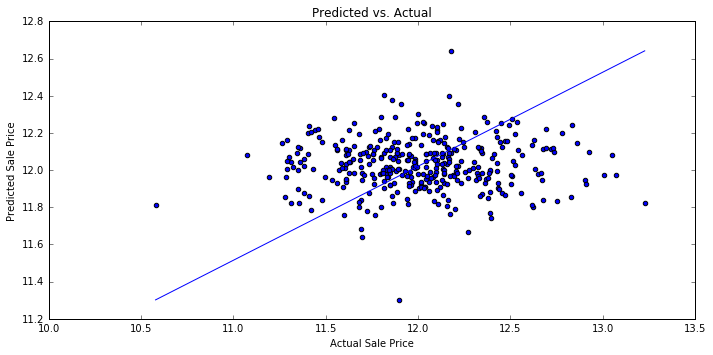

In [149]:
from sklearn.cross_validation import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(xTrain.values, tTrain.values)
clf = RandomForestRegressor(n_estimators=500, n_jobs=-1)

clf.fit(X_train1, y_train1)
y_pred = clf.predict(X_test1)

y_test1 = y_test1
plt.figure(figsize=(10, 5))
plt.scatter(y_test1, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test1), max(y_test1)], [min(y_pred), max(y_pred)])
plt.tight_layout()

In [150]:
train_test_data_new.shape, xTrain.shape, tTrain.shape, xTest.shape

((5837, 229), (1460, 229), (1460, 1), (4377, 229))

In [151]:
'''Get names of the features of entire data'''
names = list(train_test_data_new.columns.values)
'''Get the feature importance of RandomForest'''
importances = clf.feature_importances_
#print len(importance)

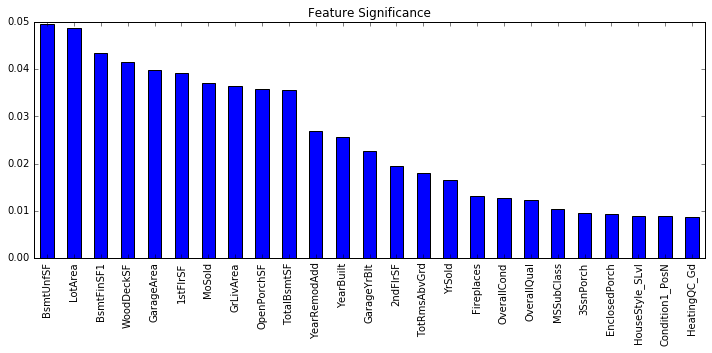

In [152]:
sorted_importances = pd.Series(importances, index = train_test_data_new.columns).sort_values(ascending=False)
sorted_importances = pd.Series(sorted_importances)
plt.figure(figsize=(10, 5))
sorted_importances.head(25).plot(kind='bar')
plt.title('Feature Significance')
plt.tight_layout()

In [153]:
from sklearn.metrics import mean_squared_error
from math import sqrt
print "Accuracy", sqrt(mean_squared_error(y_pred, y_test1, multioutput='raw_values'))

Accuracy 0.407565970138


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:1531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:1531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:1531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/2.7/lib/p

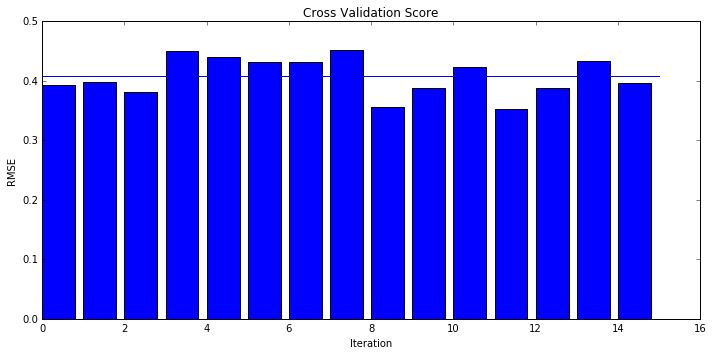

In [156]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.cross_validation import cross_val_score

scorer = make_scorer(mean_squared_error, False)

clf = RandomForestRegressor(n_estimators=500)
cv_score = np.sqrt(-cross_val_score(estimator=clf, X=xTrain.values, y=tTrain.values, cv=15, scoring = scorer))

plt.figure(figsize=(10,5))
plt.bar(range(len(cv_score)), cv_score)
plt.title('Cross Validation Score')
plt.ylabel('RMSE')
plt.xlabel('Iteration')

plt.plot(range(len(cv_score) + 1), [cv_score.mean()] * (len(cv_score) + 1))
plt.tight_layout()